# LIBRARY

In [68]:
import numpy as np
import mido
import os
import matplotlib.pyplot as plt
import pandas as pd
import time

# VECTOR OF MELODY - M

In [69]:
def return_melody(file):
    M = []
    for i, track in enumerate(file.tracks):
        for msg in track:
            if msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0): 
                M.append(msg.note)
    return M

# DELTA VECTOR - Vm

In [70]:
def return_delta(M):
    Vm = []
    for i in range(len(M)-1):
            delta = M[i+1] - M[i]
            Vm.append(delta)
    return Vm

# NOTE DURATION (RHYTHM VECTOR) - Rm

In [71]:
# Function to convert ticks to time in seconds, TEST2
def tick_to_time_test2(ticks, tempo, ticks_per_quarter_note):
    
    duration_per_tick = tempo / ticks_per_quarter_note
    
    note_duration = duration_per_tick * ticks
    
    note_duration_seconds = note_duration / 1000000
    
    
    return note_duration_seconds

In [72]:
def loop_duration_note(mid):

    # Get ticks per beat from the MIDI file
    ticks_per_beat = mid.ticks_per_beat

    #list of note duration
    note_duration_test2 = []

    for i, track in enumerate(mid.tracks): 
        for msg in track:
            
            if msg.type == 'set_tempo': #take tempo of ticks -> track 0
                current_tempo = msg.tempo

            elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
                # Note off: calculate the duration
                note_duration_test2.append(tick_to_time_test2(msg.time, current_tempo, ticks_per_beat)) 

    return note_duration_test2

# PATH SONG

In [73]:
def name_all_song(path):

    lista_nomi = []
    dir_list = os.listdir(path)
    

    for i in range(len(dir_list)): 
        song_2 = path + '\\' + dir_list[i] 
        lista_nomi.append(song_2) #save name song
        
    return lista_nomi

# DEFINITION OF K (LENGTH OF THE SUBVECTOR)

In [74]:
def find_k (song1, song2):
    
    min_M = len(song2["M"])
    if len(song1["M"]) < len(song2["M"]):
        min_M = len(song1["M"])
    min_Vm = len(song2["Vm"])
    if(len(song1["Vm"]) < len(song2["Vm"])):
        min_Vm = len(song1["Vm"])

    if(min_M < min_Vm):
        k = np.random.randint(low=min_M, high=min_Vm)
    else:
        k = np.random.randint(low = min_Vm, high=min_M)

    return k

# CREATION OF SUBVECTOR (FOR THE MELODY AND RHYTHM) - Sk

In [75]:
def return_subset_of_Vm(Vm, k):
    return Vm[0:k]

In [76]:
def return_subset_of_Rm(Rm, k):
    return Rm[0:k]

# COMPUTE THE WEIGHTED MELODIC/RHYTMIC VECTORIAL DISTANCE BETWEEN SUBVECTOR

In [77]:
#s1 : sub_Vm_1
#s2 : sub_Vm_2
def melodic_vector_distance(s1, s2, list_song):
    
    distance = 0
    
    #calculate the eeuclidean distance
    for i in range(len(s1)):
        
        punto1 = s1[i] * (i+1) 
        punto2 = s2[i] * (i+1)
        
        absolute_value = abs(punto1 - punto2)
        sqrt_abs_value = np.power(absolute_value, 2)
        distance += sqrt_abs_value

    distance_sub_Vm = np.sqrt(distance)
    
    return distance_sub_Vm

# JACCARD SIMILARITY

In [78]:
# for Vm and Rm
def jaccard_similarity(vector_a, vector_b):
    
    num = vector_a.intersection(vector_b)
    den = vector_a.union(vector_b)
    jaccard_result = float(len(num))/float(len(den))

    return round(jaccard_result, 4)

# SUBSET SHINGLES

In [79]:
def return_subset_shingles(subset_Vm, k_shingles):

    list_shin = []

    for i in range(len(subset_Vm)- k_shingles +1):
        list_shin.append(subset_Vm[i:i+k_shingles])
    
    return list_shin

# AVERAGE JACCARD SIMILARITY

In [80]:
#Vm
def average_jaccard_similarity(list_song, k, k_shingles):
    
    #1) creation of subset Vm1 and subset Vm2
    subset_Vm1 = return_subset_of_Vm(list_song[0]["Vm"], k) #Sk(Vm1)
    subset_Vm2 = return_subset_of_Vm(list_song[1]["Vm"], k) #Sk(Vm2)

    #2)divide subset based on len k_shingles
    k_shingles_x = return_subset_shingles(subset_Vm1, k_shingles)
    k_shingles_y = return_subset_shingles(subset_Vm2, k_shingles)

    #3)Compute local jaccard similarity / initialize average jaccard similarity

    #total
    similarities = []

    for x in k_shingles_x:

        set_x = set(x)

        local_similarities = []
        
        for y in k_shingles_y:

            set_y = set(y)
            similarity = jaccard_similarity(set_x, set_y)
            local_similarities.append(similarity)

        if local_similarities:
            
            max_similarity = max(local_similarities) 
            similarities.append(max_similarity)
    
    #4) compute the average similaities
    if similarities:
        return sum(similarities) / len(similarities)
    else:
        return 0




In [81]:
#Rm
def average_jaccard_similarity_Rm(list_song, k, k_shingles):
    
    #1) creation of subset Vm1 and subset Vm2
    subset_Rm1 = return_subset_of_Rm(list_song[0]["Rm"], k) #Sk(Vm1)
    subset_Rm2 = return_subset_of_Rm(list_song[1]["Rm"], k) #Sk(Vm2)

    #2)divide subset based on len k_shingles
    k_shingles_x = return_subset_shingles(subset_Rm1, k_shingles)
    k_shingles_y = return_subset_shingles(subset_Rm2, k_shingles)

    #3)Compute local jaccard similarity / initialize average jaccard similarity

    #total
    similarities = []

    for x in k_shingles_x:

        set_x = set(x)

        local_similarities = []
        
        for y in k_shingles_y:

            set_y = set(y)

            similarity = jaccard_similarity(set_x, set_y)
            local_similarities.append(similarity)

        if local_similarities:
            
            max_similarity = max(local_similarities) 
            similarities.append(max_similarity)
    
    #4) compute the average similaities
    if similarities:
        return sum(similarities) / len(similarities)
    else:
        return 0




# FRAGMENT TO MELODY CORRELATION FACTOR - PART OF FUZZY DEEP

In [82]:
def all_lambda(k_shingles_x, k_shingles_y):

    #list lambda
    list_lambdas = []

    for s_y in k_shingles_y:
        
        #save all the distance before product
        distances = []

        for s_x in k_shingles_x:  
            distance_norm = np.linalg.norm(np.array(s_y) - np.array(s_x)) / max(np.linalg.norm(s_y), np.linalg.norm(s_x)) #d(sx,sy)
            distances.append(distance_norm)
        
        one_minus_distance = [1- d for d in distances] # (1-d(sy,sx))
        product_dist = np.prod(one_minus_distance)
        lambda_sy_Mx = 1 - product_dist
        list_lambdas.append(lambda_sy_Mx)

    return list_lambdas


# PLOT LOOP K - AVERAGE JACCARD SIMILARITY

In [83]:
def plot(k_shi,l_ajs_vm,l_ajs_rm, n_case):

    # Create the scatter plot with customization
    plt.plot(k_shi, l_ajs_vm,marker = 'o', label = 'ajs vm')
    plt.plot(k_shi, l_ajs_rm, marker = 'o', label = 'ajs rm')

    # Add labels and title
    plt.xlabel('len k shingles', fontsize=14)
    plt.ylabel('average jaccard similarity', fontsize=14)
    plt.title(f'case: {n_case}', fontsize=16)

    plt.legend(loc='upper left')

    # Show the plot
    plt.show()


# PLOT LOOP K - FUZZY

In [84]:
def plot_fx(shi, Fx, n_case):
    #colors = ['red', 'green', 'blue', 'purple', 'orange']  # Colors for each point

    # Create the scatter plot with customization
    plt.plot(shi, Fx, marker = 'o', label = 'Fuzzy')
    #plt.plot(k_shi, l_ajs_rm, marker = 'o', label = 'ajs_rm')

    # Add labels and title
    plt.xlabel('len k shingles', fontsize=14)
    plt.ylabel('fuzzy vectorial coefficient', fontsize=14)
    plt.title(f'case{n_case}', fontsize=16)

    plt.legend(loc='upper left')

    # Show the plot
    plt.show()


# MAIN

In [85]:
dict = {
    "name_song": "",
    "M": [],
    "Vm": [],
    "Rm": [],
}

#time
t_final = 0

#list dict for each song
list_song_ori = []
list_song_plag = []

#final ajs
list_finals = []

#list_real_song
list_name_ori = name_all_song(path = "data\midi\dataset_real_ori")
list_name_plag = name_all_song(path = "data\midi\dataset_real_plag")

#scorro le canzoni: -> update folder
for i in range(len(list_name_ori)):

    #opne file midi
    mid_ori = mido.MidiFile(list_name_ori[i])
    mid_plag = mido.MidiFile(list_name_plag[i])

    #CREO M
    M_ori = return_melody(mid_ori)
    M_plag = return_melody(mid_plag)

    #CREO Vm
    Vm_ori = return_delta(M_ori)
    Vm_plag = return_delta(M_plag)

    #CREO Rm
    #list to store note duration test 2
    Rm_ori = loop_duration_note(mid_ori)
    Rm_plag = loop_duration_note(mid_plag)

    dict_ori = {"name_song": mid_ori.filename, "M":M_ori, "Vm":Vm_ori, "Rm":Rm_ori}
    list_song_ori.append(dict_ori)
    dict_plag = {"name_song": mid_plag.filename, "M":M_plag, "Vm":Vm_plag, "Rm":Rm_plag}
    list_song_plag.append(dict_plag)

for i in range(len(list_song_plag)):

    #creo kappa 
    k = find_k(list_song_ori[i], list_song_plag[i])

    #find subset of Vm for the 2 songs based on kappa
    sub_Vm_1 = return_subset_of_Vm(list_song_ori[i]["Vm"], k) #sk (My)
    sub_Vm_2 = return_subset_of_Vm(list_song_plag[i]["Vm"], k) #sk (Mx)

    #calulate the distance for Vm used s1, s2 (subsets)
    dist_sub_Vm = melodic_vector_distance(sub_Vm_1, sub_Vm_2, [])

    #find the subset of Rm for the 2 songs based on kappa
    sub_Rm_1 = return_subset_of_Rm(list_song_ori[i]["Rm"], k) #s1
    sub_Rm_2 = return_subset_of_Rm(list_song_plag[i]["Rm"], k) #s2

    ##calulate the distance for Rm used z1, z2 (subsets)
    dist_sub_Rm = melodic_vector_distance(sub_Rm_1, sub_Rm_2, [])

    #start time for each songs
    t0 = time.time()

    #jaccard similarity
    js_vm = jaccard_similarity(set(sub_Vm_1), set(sub_Vm_2))
    js_rm = jaccard_similarity(set(sub_Rm_1), set(sub_Rm_2))

    #time jaccard
    t_final = t_final + (time.time()-t0)

    #k_shingles test
    k_shingles = 5

    #ajs ckeck list
    list_ajs = [list_song_ori[i], list_song_plag[i]]

    #average jaccard similarity
    ajs_vm = average_jaccard_similarity(list_ajs, k, k_shingles)
    ajs_rm = average_jaccard_similarity_Rm(list_ajs, k, k_shingles)

    #save
    check = {"plag_song": list_song_plag[i]["name_song"], "original_song": list_song_ori[i]["name_song"], "ajs_vm": ajs_vm, "ajs_rm": ajs_rm}
    list_finals.append(check)

#THRESHOLD
list_threshold = []

list_threshold_ori = []
list_threshold_plag = []

# tm, tr
for i in list_finals:
    if i["ajs_vm"] > 0.2 and i["ajs_rm"] > 0.15 :
        list_threshold.append(i)
        for y,z in zip(list_song_ori, list_song_plag):
            if i["original_song"] == y["name_song"]:
                list_threshold_ori.append(y)
            if i["plag_song"] == z["name_song"]:
                list_threshold_plag.append(z)

# FUZZY
for i in range(len(list_threshold)): 

    k = find_k(list_threshold_ori[i], list_threshold_plag[i])

    #creation Sk(Vm)
    sub_Vm_y = return_subset_of_Vm(list_threshold_ori[i]["Vm"], k) #sk (My)
    sub_Vm_x = return_subset_of_Vm(list_threshold_plag[i]["Vm"], k) #sk (Mx)

    #k -> shingles
    shi = 5

    #2)divide subset based on len k_shingles
    k_shingles_y = return_subset_shingles(sub_Vm_y, shi) # sy E sk(My)
    k_shingles_x = return_subset_shingles(sub_Vm_x, shi) # sx E sk(Mx)

    #compute lambdas
    lambda_factors = all_lambda(k_shingles_x, k_shingles_y)
    #compute fuzzy
    F_My_Mx = sum(lambda_factors) / len(list_threshold_ori[i]["Vm"])

    list_threshold[i]["F_My_Mx"] = F_My_Mx
    
#FINAL

alpha = 0.75

final = []

for i in list_threshold:
    if i["F_My_Mx"] >= alpha:
        final.append(i)


<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\811643147.py:19: SyntaxWarning: invalid escape sequence '\m'
  list_name_ori = name_all_song(path = "data\midi\dataset_real_ori")
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\811643147.py:20: SyntaxWarning: invalid escape sequence '\m'
  list_name_plag = name_all_song(path = "data\midi\dataset_real_plag")
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\1502971217.py:15: RuntimeWarning: overflow encountered in scalar add
  distance += sqrt_abs_value
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\1502971217.py:17: RuntimeWarning: invalid value encountered in sqrt
  distance_sub_Vm = np.sqrt(distance)
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\3397415913.py:12: RuntimeWarning: invalid value encountered in scalar divide
  distan

## PLAGIARISM SONG THAT PASS THRESHOLD tm = 0.2, tr = 0.15 AND alpha THRESHOLD (FOR FUZZY) = 0.75

In [86]:
df_final_main = pd.DataFrame(final)
df_final_main

,plag_song,original_song,ajs_vm,ajs_rm,F_My_Mx
0,data\midi\dataset_real_plag\case10_Schenkt uns...,data\midi\dataset_real_ori\case10_Anftrag Deut...,0.805920,0.956145,0.950000
1,data\midi\dataset_real_plag\case17_perhaps.mid,data\midi\dataset_real_ori\case17_ma este meg.mid,0.835256,0.678252,0.800000
2,data\midi\dataset_real_plag\case19_Till you.mid,data\midi\dataset_real_ori\case19_phantom Song...,0.574524,0.379038,0.822222
3,data\midi\dataset_real_plag\case1_song_b.mid,data\midi\dataset_real_ori\case1_song_a.mid,0.711376,0.870759,0.924528
4,data\midi\dataset_real_plag\case21_Filion Fami...,data\midi\dataset_real_ori\case21_Here We Are ...,0.506889,0.397879,0.904762
5,data\midi\dataset_real_plag\case22_Chariots of...,data\midi\dataset_real_ori\case22_City of Viol...,0.299693,0.314287,0.789474
6,data\midi\dataset_real_plag\case25_Advert for ...,data\midi\dataset_real_ori\case25_There is not...,0.300080,0.409035,0.765625
7,data\midi\dataset_real_plag\case28_my sweet lo...,data\midi\dataset_real_ori\case28_he so fine.mid,0.813824,0.628334,0.820000
8,data\midi\dataset_real_plag\case4_我爱你中国.mid,data\midi\dataset_real_ori\case4_十月里响起一声春雷.mid,0.804242,0.803677,0.927614


In [87]:
print("Calculating all Jaccard Similarities without MinHash took %.2f sec\n"% t_final)

Calculating all Jaccard Similarities without MinHash took 0.00 sec



# MAIN LOOP K (RESULTS OF AVERAGE JACCARD SIMILARITY LETTING VARY THE LENGTH OF K)

<>:16: SyntaxWarning: invalid escape sequence '\B'
<>:17: SyntaxWarning: invalid escape sequence '\B'
<>:16: SyntaxWarning: invalid escape sequence '\B'
<>:17: SyntaxWarning: invalid escape sequence '\B'
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\2224773629.py:16: SyntaxWarning: invalid escape sequence '\B'
  list_name_ori = name_all_song(path = "BMMDet_MPDSet-master\BMMDet_MPDSet-master\data\midi\dataset_real_ori")
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\2224773629.py:17: SyntaxWarning: invalid escape sequence '\B'
  list_name_plag = name_all_song(path = "BMMDet_MPDSet-master\BMMDet_MPDSet-master\data\midi\dataset_real_plag")


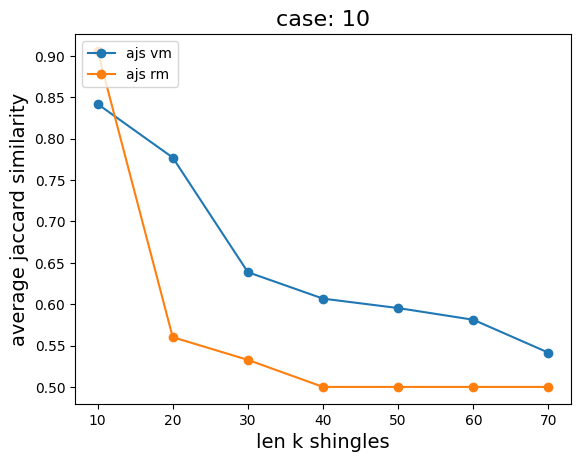

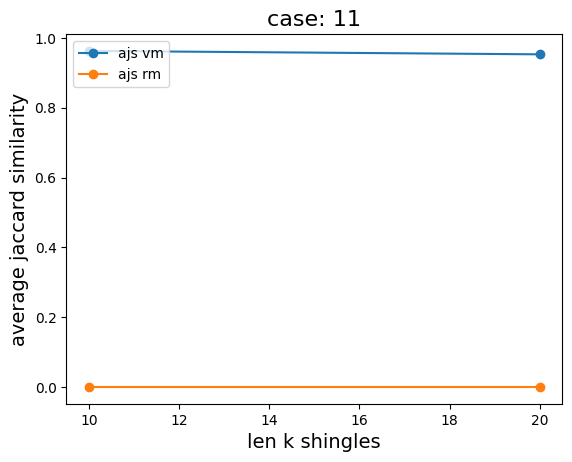

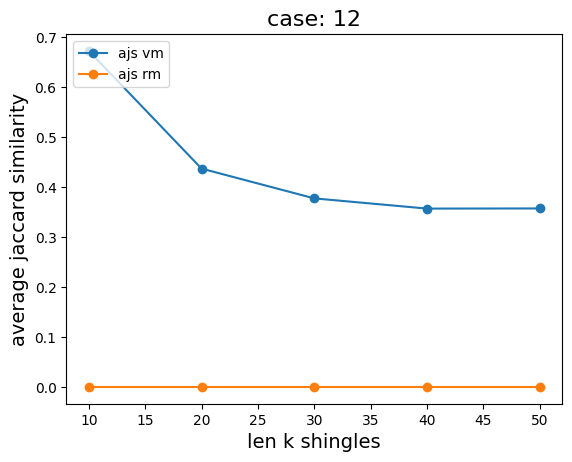

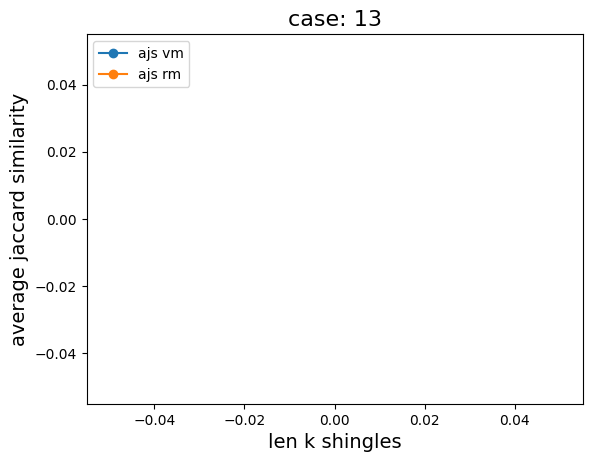

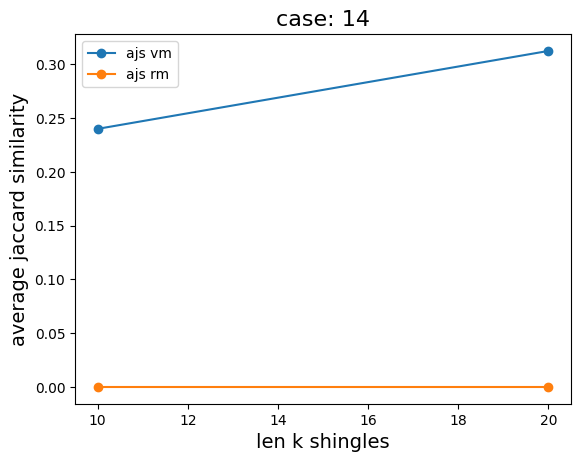

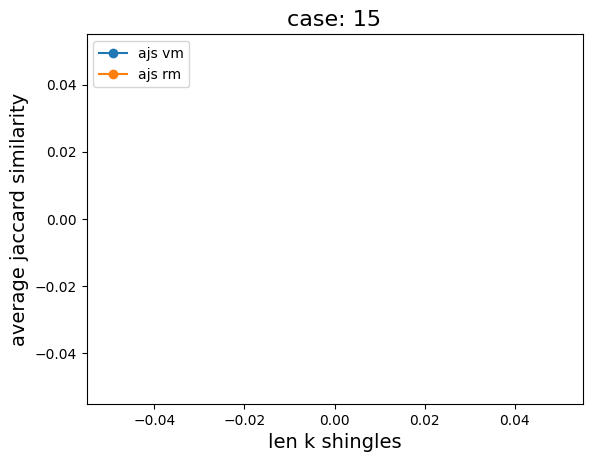

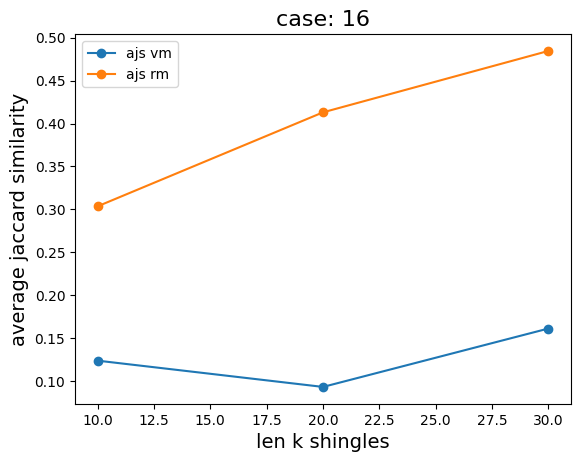

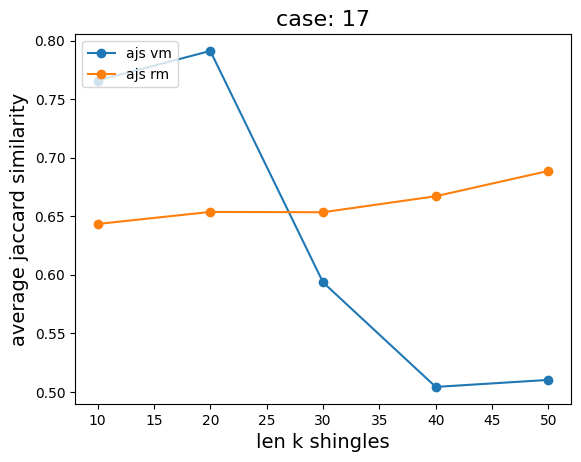

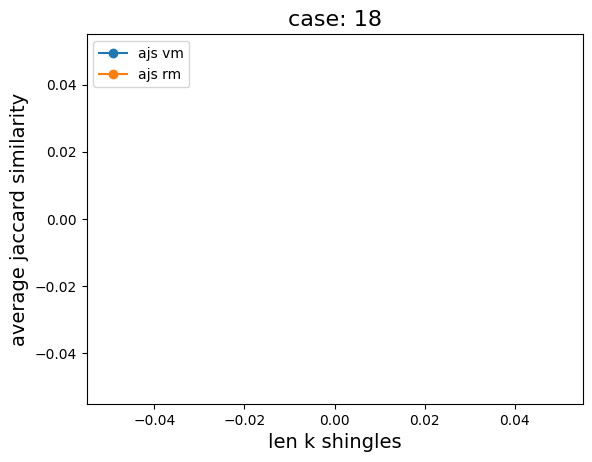

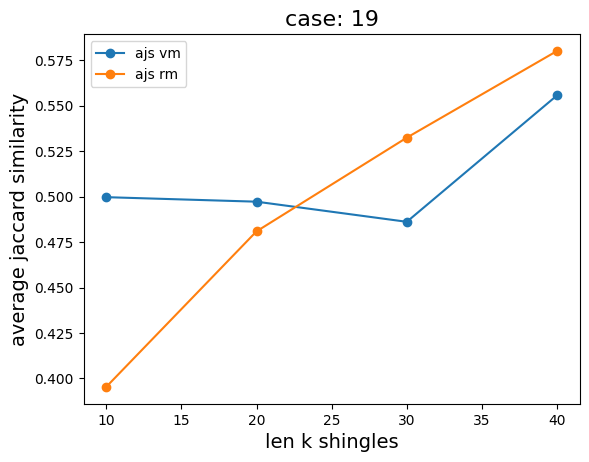

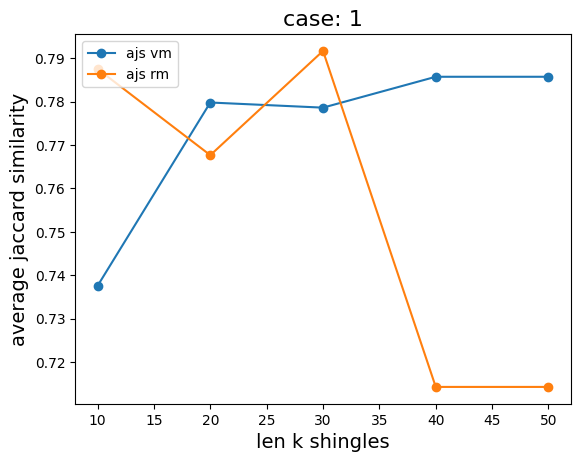

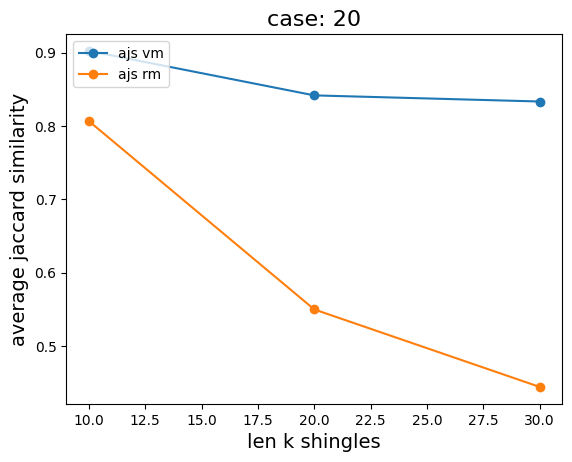

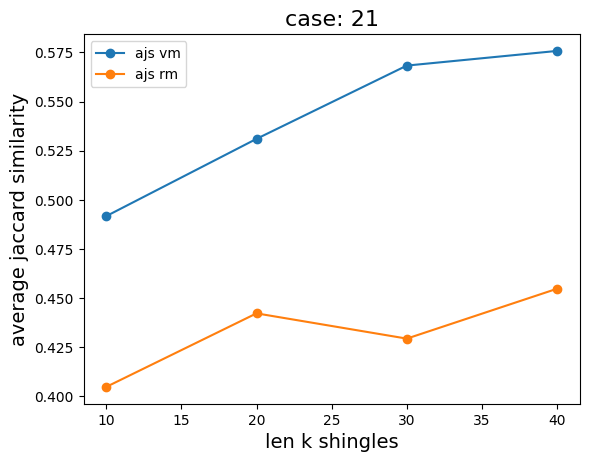

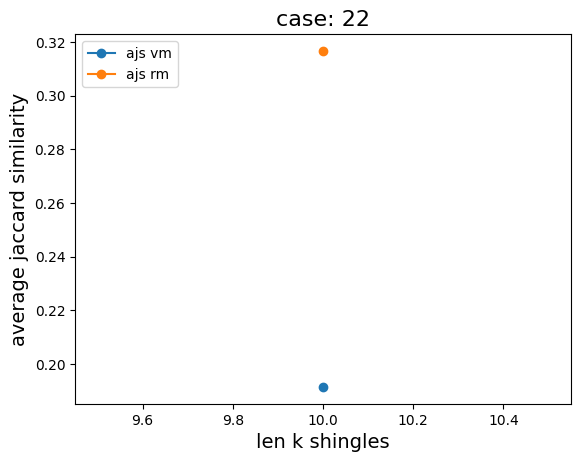

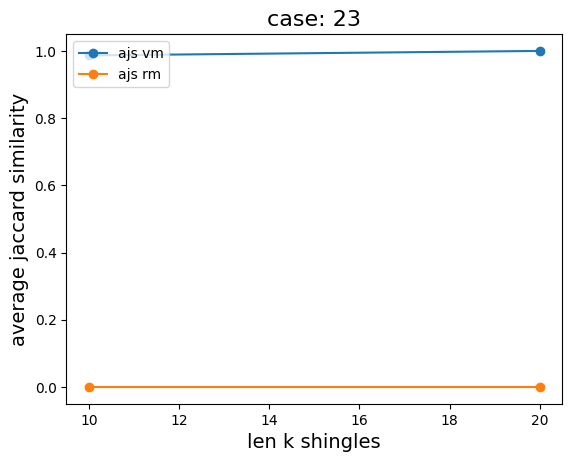

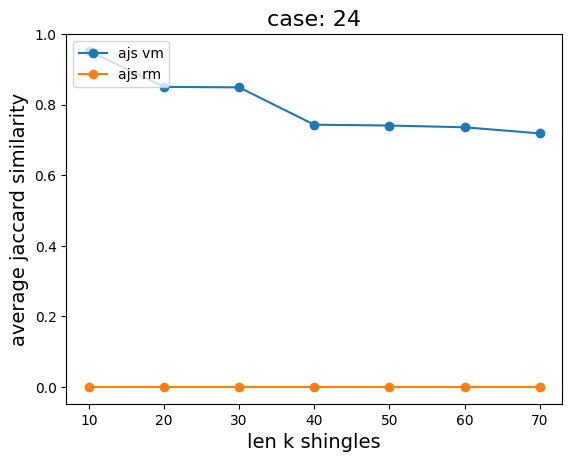

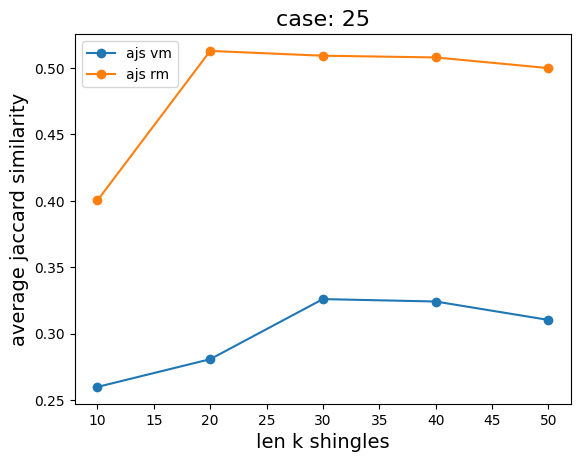

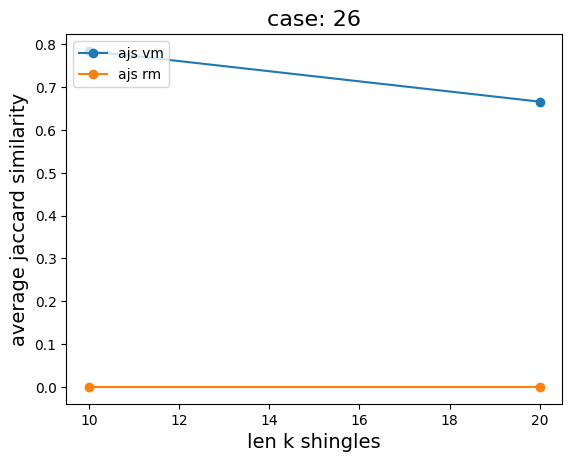

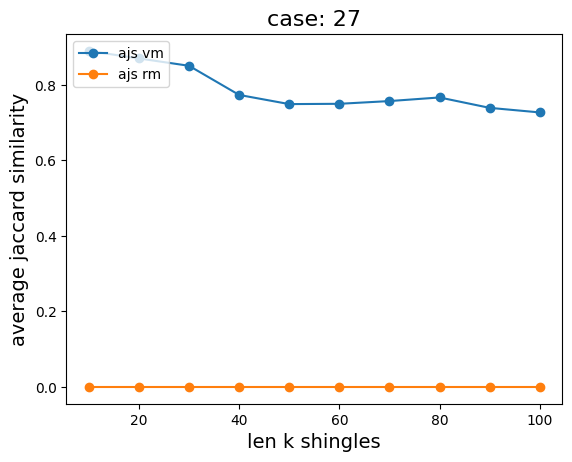

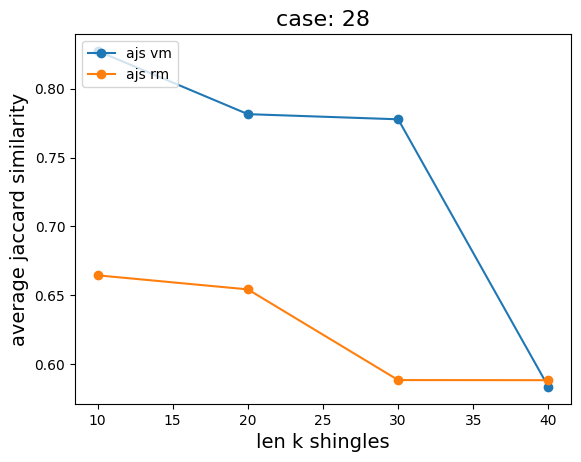

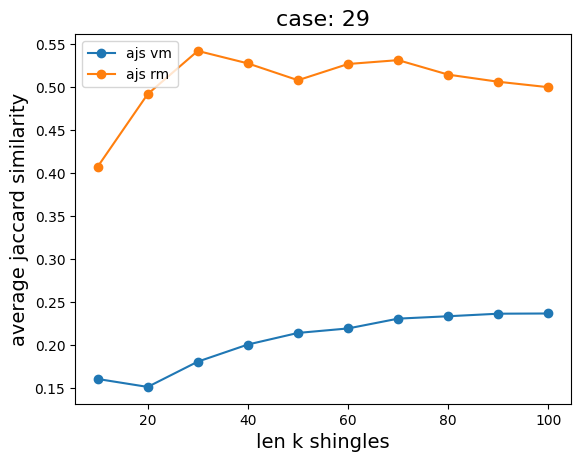

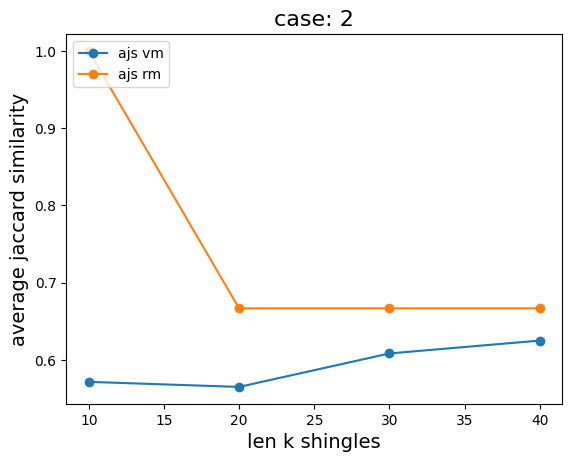

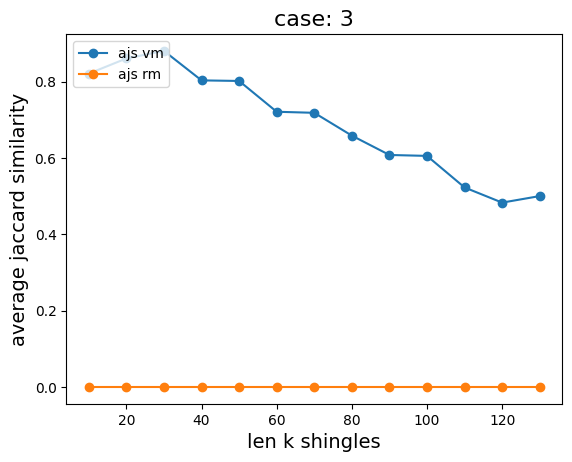

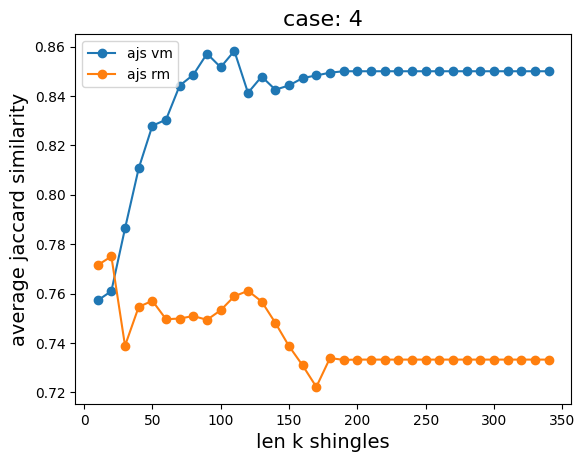

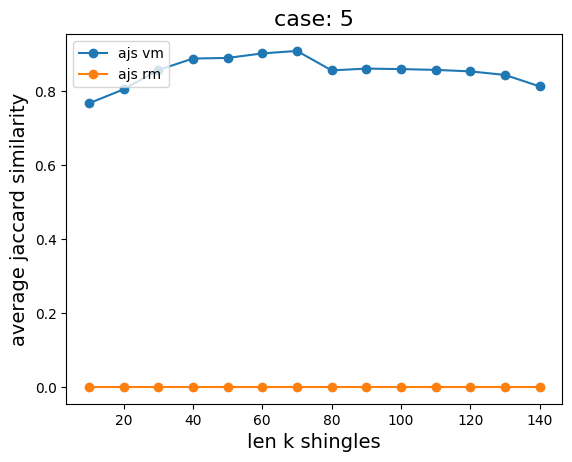

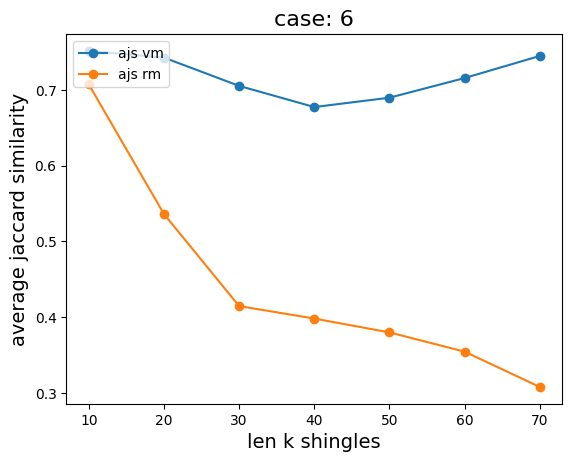

C:\Users\elped\AppData\Local\Temp\ipykernel_1720\1502971217.py:15: RuntimeWarning: overflow encountered in scalar add
  distance += sqrt_abs_value
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\1502971217.py:17: RuntimeWarning: invalid value encountered in sqrt
  distance_sub_Vm = np.sqrt(distance)


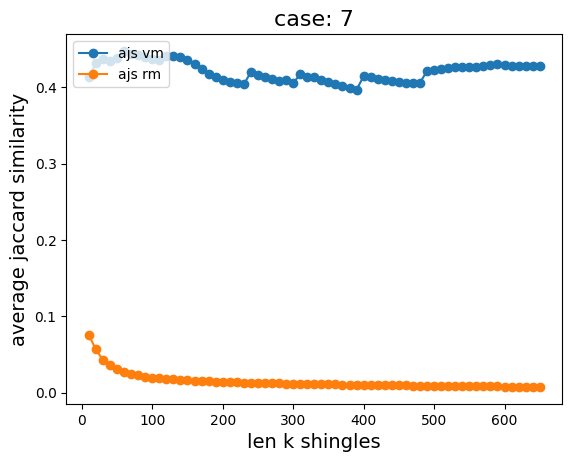

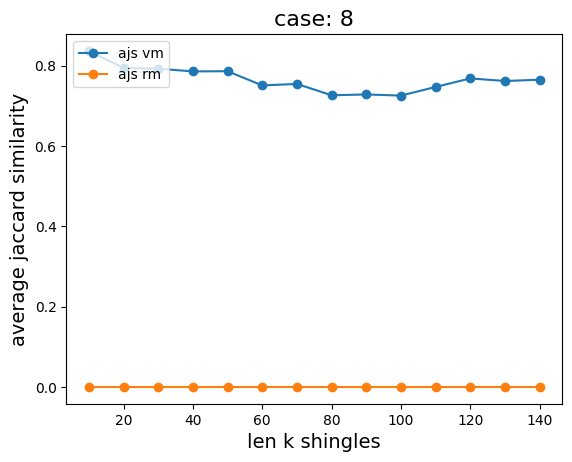

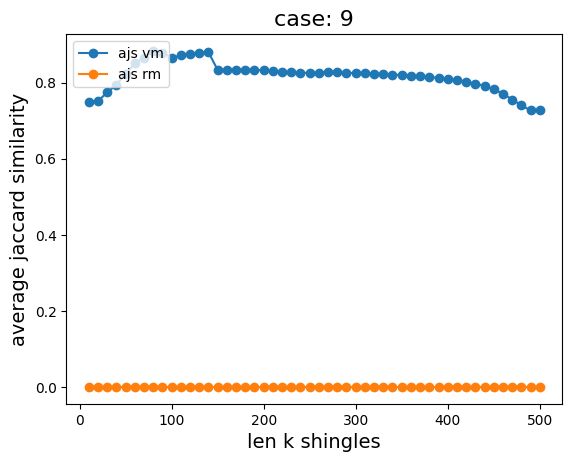

In [88]:
dict = {
    "name_song": "",
    "M": [],
    "Vm": [],
    "Rm": [],
}

#list dict for each song
list_song_ori = []
list_song_plag = []

#final ajs
list_finals = []

#list_real_song
list_name_ori = name_all_song(path = "BMMDet_MPDSet-master\BMMDet_MPDSet-master\data\midi\dataset_real_ori")
list_name_plag = name_all_song(path = "BMMDet_MPDSet-master\BMMDet_MPDSet-master\data\midi\dataset_real_plag")

#scorro le canzoni: -> update folder
for i in range(len(list_name_ori)):

    #opne file midi
    mid_ori = mido.MidiFile(list_name_ori[i])
    mid_plag = mido.MidiFile(list_name_plag[i])

    #CREO M
    M_ori = return_melody(mid_ori)
    M_plag = return_melody(mid_plag)

    #CREO Vm
    Vm_ori = return_delta(M_ori)
    Vm_plag = return_delta(M_plag)

    #CREO Rm
    #list to store note duration test 2
    Rm_ori = loop_duration_note(mid_ori)
    Rm_plag = loop_duration_note(mid_plag)

    dict_ori = {"name_song": mid_ori.filename, "M":M_ori, "Vm":Vm_ori, "Rm":Rm_ori}
    list_song_ori.append(dict_ori)
    dict_plag = {"name_song": mid_plag.filename, "M":M_plag, "Vm":Vm_plag, "Rm":Rm_plag}
    list_song_plag.append(dict_plag)

#test dizio for plot
list_plot = []
list_casi = [10,11,12,13,14,15,16,17,18,19,1,20,21,22,23,24,25,26,27,28,29,2,3,4,5,6,7,8,9]

for i in range(len(list_song_plag)):

    #creo kappa (SPECIFICARE K)
    k = find_k(list_song_ori[i], list_song_plag[i])

    #find subset of Vm for the 2 songs based on kappa
    sub_Vm_1 = return_subset_of_Vm(list_song_ori[i]["Vm"], k) #sk (My)
    sub_Vm_2 = return_subset_of_Vm(list_song_plag[i]["Vm"], k) #sk (Mx)

    #calulate the distance for Vm used s1, s2 (subsets)
    dist_sub_Vm = melodic_vector_distance(sub_Vm_1, sub_Vm_2, [])

    #find the subset of Rm for the 2 songs based on kappa
    sub_Rm_1 = return_subset_of_Rm(list_song_ori[i]["Rm"], k) #s1
    sub_Rm_2 = return_subset_of_Rm(list_song_plag[i]["Rm"], k) #s2
    
    ##calulate the distance for Rm used z1, z2 (subsets)
    dist_sub_Rm = melodic_vector_distance(sub_Rm_1, sub_Rm_2, [])

    #jaccard similarity
    js_vm = jaccard_similarity(set(sub_Vm_1), set(sub_Vm_2))
    js_rm = jaccard_similarity(set(sub_Rm_1), set(sub_Rm_2))
    
    #update dict_plot:
    #dict_plot = {}
    list_k_shingles = []
    list_ajs_vm = []
    list_ajs_rm = []

    #k_shingles
    for k_shingles in range(10,k,10):
        
        #ajs ckeck list
        list_ajs = [list_song_ori[i], list_song_plag[i]]
        
        #average jaccard similarity
        ajs_vm = average_jaccard_similarity(list_ajs, k, k_shingles)
        ajs_rm = average_jaccard_similarity_Rm(list_ajs, k, k_shingles)

        list_ajs_vm.append(ajs_vm)
        list_ajs_rm.append(ajs_rm)
        list_k_shingles.append(k_shingles)

    plot(list_k_shingles,list_ajs_vm,list_ajs_rm,list_casi[i])


# LOOP K FOR FUZZY (RESULTS OF FUZZY VECTORIAL BASED COEFFICIENT LETTING VARY THE LENGTH OF K)

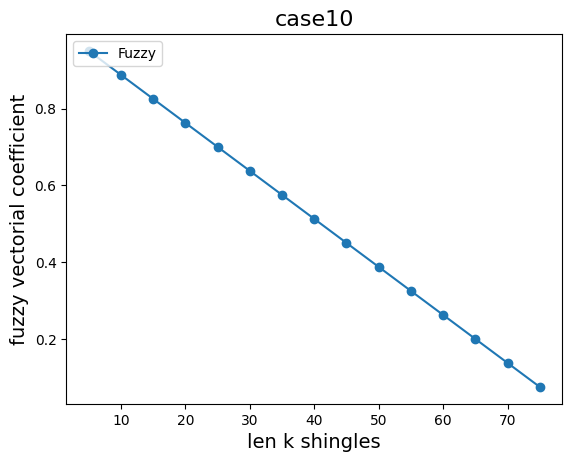

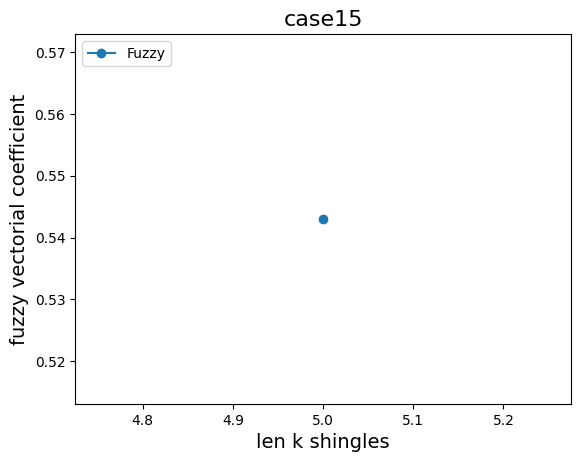

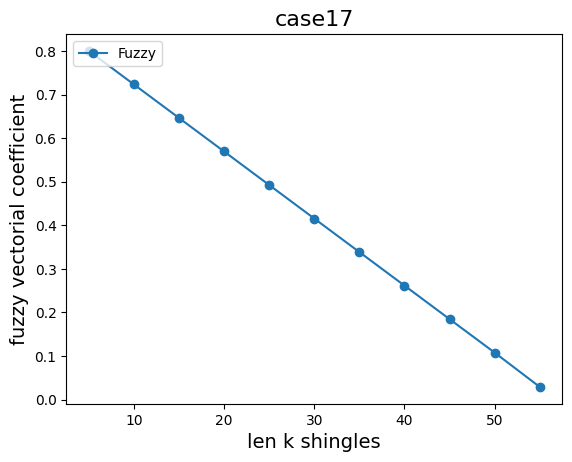

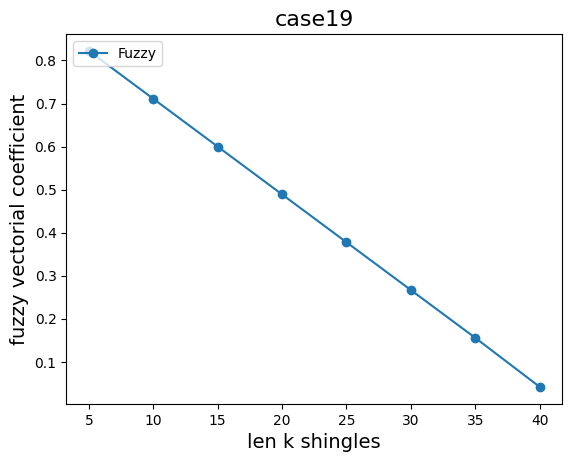

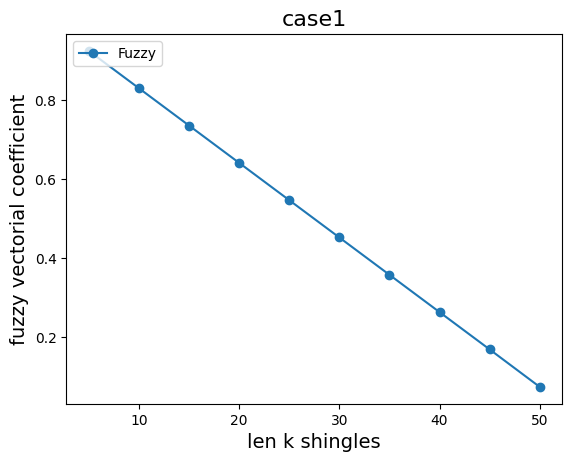

C:\Users\elped\AppData\Local\Temp\ipykernel_1720\3397415913.py:12: RuntimeWarning: invalid value encountered in scalar divide
  distance_norm = np.linalg.norm(np.array(s_y) - np.array(s_x)) / max(np.linalg.norm(s_y), np.linalg.norm(s_x)) #d(sx,sy)


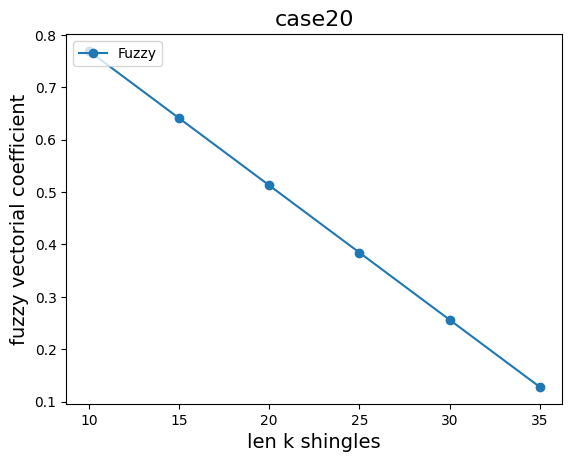

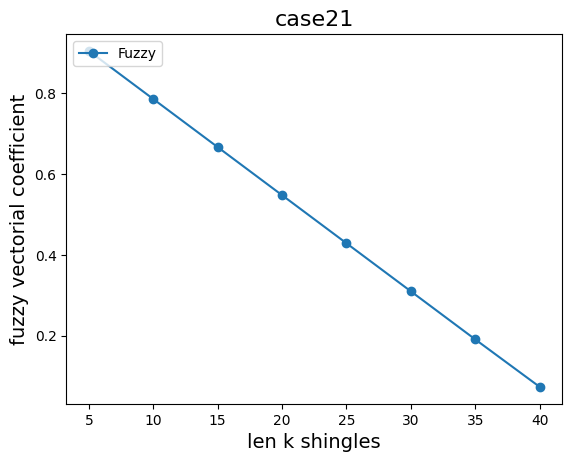

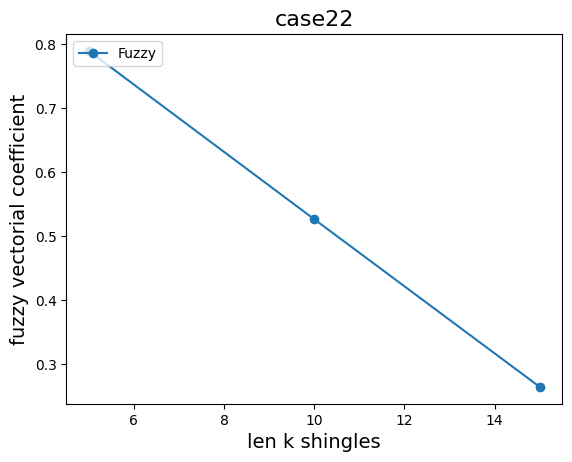

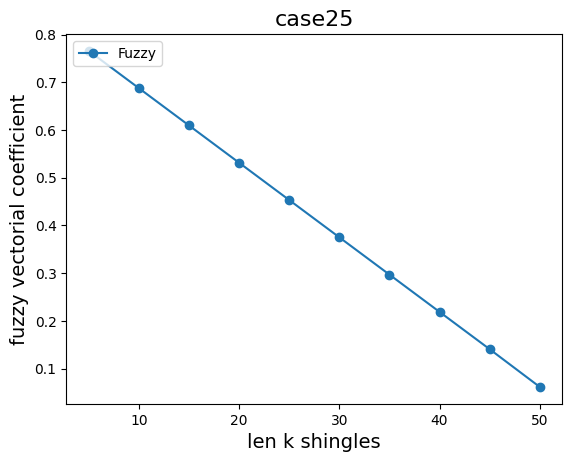

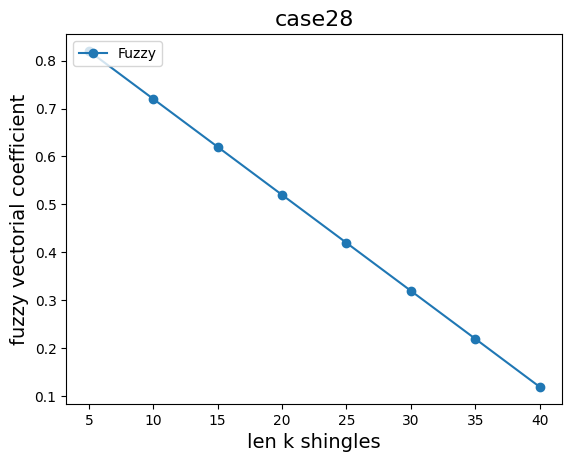

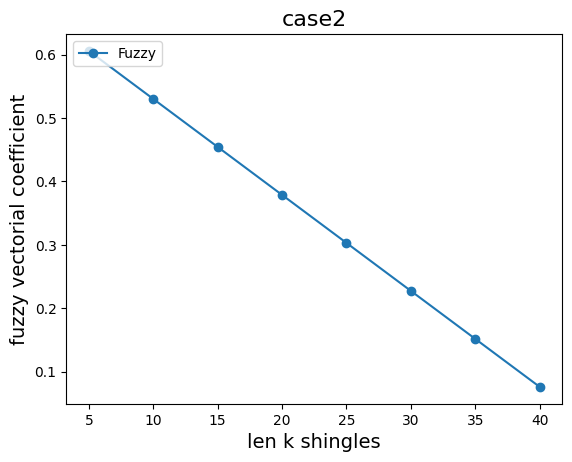

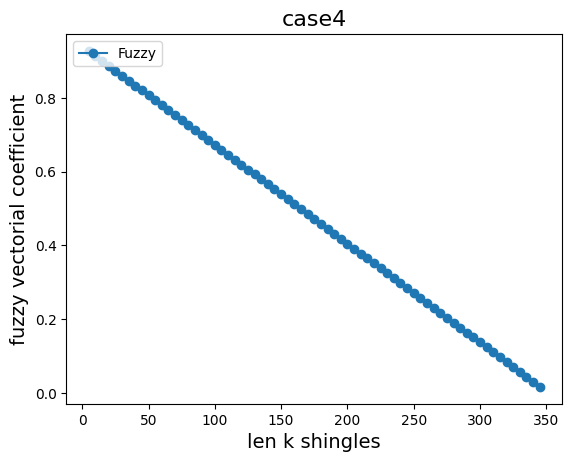

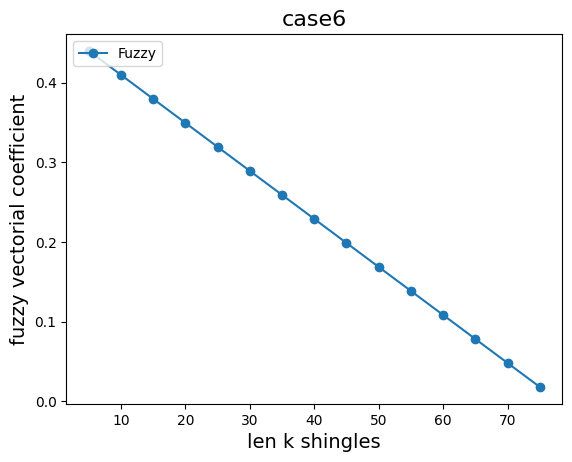

In [89]:
list_casi = [10,15,17,19,1,20,21,22,25,28,2,4,6]

#fuzzy

for i in range(len(list_threshold)): #or list_threshold_ori

    #print("My:", list_threshold_ori[i]["name_song"])
    #print("Mx:", list_threshold_plag[i]["name_song"])

    k = find_k(list_threshold_ori[i], list_threshold_plag[i])

    #creation Sk(Vm)
    sub_Vm_y = return_subset_of_Vm(list_threshold_ori[i]["Vm"], k) #sk (My)
    sub_Vm_x = return_subset_of_Vm(list_threshold_plag[i]["Vm"], k) #sk (Mx)
    
    list_shi = []
    list_F = []
    
    for shi in range(5,k,5):
        
        #2)divide subset based on len k_shingles
        k_shingles_y = return_subset_shingles(sub_Vm_y, shi) # sy E sk(My) #ATTENZIONE SOTITUIRE k_shingles con shi
        k_shingles_x = return_subset_shingles(sub_Vm_x, shi) # sx E sk(Mx) #ATTENZIONE SOTITUIRE k_shingles con shi

        #compute lambdas
        lambda_factors = all_lambda(k_shingles_x, k_shingles_y)
        #compute fuzzy
        F_My_Mx = sum(lambda_factors) / len(list_threshold_ori[i]["Vm"])
        
        list_shi.append(shi)
        list_F.append(F_My_Mx)

        list_threshold[i]["F_My_Mx"] = F_My_Mx
    
    plot_fx(list_shi, list_F, list_casi[i])


# MINHASH TECHINQUE FOR JACCARD SIMILARITY COMPUTATION

In [90]:
#lista ori
list_ori_vm = []
doc_ori_vm = {}
for i in list_song_ori:
    list_ori_vm.append(i["Vm"])
    doc_ori_vm[i["name_song"]] = i["Vm"]
#doc_ori_vm

#lista plag
list_plag_vm = []
doc_plag_vm = {}
for i in list_song_plag:
    list_plag_vm.append(i["Vm"])
    doc_plag_vm[i["name_song"]] = i["Vm"]
#doc_plag_vm

#lista plag
list_ori_rm = []
doc_ori_rm = {}
for i in list_song_ori:
    list_ori_rm.append(i["Rm"])
    doc_ori_rm[i["name_song"]] = i["Rm"]
#doc_ori_rm

#lista plag
list_plag_rm = []
doc_plag_rm = {}
for i in list_song_plag:
    list_plag_rm.append(i["Rm"])
    doc_plag_rm[i["name_song"]] = i["Rm"]
#doc_plag_rm

In [91]:
import time
import hashlib

def compute_shingles(doc_names, docs_to_analyze, shingle_lenght=9): #shingke_lengh: numero di caratteri da prendere!!
    docs_shingle_sets = {} #dizionario contenete chiave -> id che indica il documento : valore -> set of shingles dell documento **
    total_shingles = 0
    num_docs = len(docs_to_analyze) #number of document
    for i in range(num_docs): #predno un documento allla volta
        # Consider one doc at a time
        doc = docs_to_analyze[i]

        # Set for all of the unique shingle IDs present in the current doc
        shingles_in_doc = set() #set is unique, creo un set per i vari shingle del documento i

        for index in range(len(doc) - shingle_lenght): #vado da zero a fine -lunghezza shingle (quindi scorro tutti i caratteri in blocchi)
            shingle = doc[index:index+shingle_lenght] #predo una parte del test che va da index a index+lunghezza shingle = 9 (blocco del testo)
            # Hash the shingle to a 32-bit integer.

            #PROVARE A TRASFORMARE LA LISTA DI NUMERI IN UNA STRINGA

            crc = int(hashlib.sha256(str(shingle).encode('utf-8')).hexdigest(), 16) % 2**32 #standard procedura (hasho il bloccco)

            # Add the hash to the list of shingles
            shingles_in_doc.add(crc) #aggiungo il blocco hashato nella lista di set

        # Store the completed list of shingles for this document in the dictionary
        doc_ID = doc_names[i]
        docs_shingle_sets[doc_ID] = shingles_in_doc #aggiungo i valori al dizionario **

        # Count the number of shingles across all documents.
        total_shingles = total_shingles + (len(doc) - shingle_lenght)

    return docs_shingle_sets, total_shingles

In [92]:
shingle_lenght = 5
t0 = time.time()

docs_shingle_sets_ori_vm, total_shingles = compute_shingles(list_name_ori, list_ori_vm, shingle_lenght)
docs_shingle_sets_plag_vm, total_shingles = compute_shingles(list_name_plag, list_plag_vm, shingle_lenght)

docs_shingle_sets_ori_rm, total_shingles = compute_shingles(list_name_ori, list_ori_rm, shingle_lenght)
docs_shingle_sets_plag_rm, total_shingles = compute_shingles(list_name_plag, list_plag_rm, shingle_lenght)

#print('Shingling ' + str(len(list_ori_vm)) + ' docs took %.2f sec.\n' % (time.time() - t0))

#print('Average shingles per doc: %.2f' % (total_shingles / len(list_ori_vm)))

In [93]:
import random #NEL CASO NON VOLESSI USARE IL NAIVE(JACCARD), RIVEDERE

def compute_MinHases(doc_names, docs_shingle_sets, num_hashes, seed = 289386372): #SEED -> usato per il random
    # Hard-coded contants
    max_shingle_ID = 2**32-1 #maximum size of permutation
    next_prime = 4294967311 # next largest prime number above 'max_shingle_ID' #c per calcolare il minhash

    # Set the seed in the random number genertor
    random.seed(seed)

    # The random hash function will take the form of:
    #   h(x) = (a*x + b) % c
    # Where 'x' is the input value, 'a' and 'b' are random coefficients,
    # and 'c' is a prime number greater than max_shingle_ID.

    # We compute the coefficients: the "random.sample(N,k)" returns the first k elements
    # of a random permutation of set of N integers
    coeffA = random.sample(range(max_shingle_ID), num_hashes) #a , crea dei coefficenti random tra 0 e max single id #sono delle liste
    coeffB = random.sample(range(max_shingle_ID), num_hashes) #b , crea dei coefficenti random tra 0 e max single id #sono delle liste
    #print(coeffA)

    # Rather than generating a random permutation of all possible shingles,
    # we'll just hash the IDs of the shingles that are *actually in the document*,
    # then take the lowest resulting hash code value. This corresponds to the index
    # of the first shingle that you would have encountered in the random order.

    all_signatures = {}

    for doc_ID in doc_names:
        # Get the shingle set for this document.
        shingle_set = docs_shingle_sets[doc_ID] #set di shingles con chiave doc_id
        #print(docs_shingle_sets['t1088'])
        #print(shingle_set)
        #print(len(shingle_set)) #intorno a 1500

        # The resulting minhash signature for this document.
        signature = [] #cento valori

        for i in range(num_hashes): #mi semnra che crei le 100 permutazioni
            # For each of the shingles actually in the document, calculate its hash code
            # using hash function 'i'.

            # Track the lowest hash ID seen. Initialize 'minHashCode' to be greater than
            # the maximum possible value output by the hash.
            min_hash_code = next_prime + 1
            #print(len(shingle_set))
            for shingle_ID in shingle_set: #per 100 volte scorro sempre lo stesso set di shingles
                #shingle_ID
                hash_code = (coeffA[i] * shingle_ID + coeffB[i]) % next_prime  #hash il singolo valore del shingle, quindi dovrei avere sempre per 100 molte lo stessp min hash ma non è cosi perchèèèèèèèèèèè???? perchè i coefficenti sono sempre diversi 
                #print(f'hash singles:{doc_ID}, {hash_code}')
                if hash_code < min_hash_code:  #mi cerco l hash più piccolo
                    min_hash_code = hash_code

            # Add the smallest hash code value as component number 'i' of the signature.
            #print(min_hash_code)
            signature.append(min_hash_code) # creo la lista contentne gli hash minimi, 
            #print(min_hash_code)

        # Store the MinHash signature for this document.
        all_signatures[doc_ID] = signature

    return all_signatures

In [94]:
#num_hashes = len(list_name_ori)
num_hashes = 1000

t0 = time.time()
#min hash for list_song_ori -> original song on Vm
docs_minhash_ori_vm = compute_MinHases(list_name_ori, docs_shingle_sets_ori_vm, num_hashes)
docs_minhash_plag_vm = compute_MinHases(list_name_plag, docs_shingle_sets_plag_vm, num_hashes)

docs_minhash_ori_rm = compute_MinHases(list_name_ori, docs_shingle_sets_ori_rm, num_hashes)
docs_minhash_plag_rm = compute_MinHases(list_name_plag, docs_shingle_sets_plag_rm, num_hashes)


print('Generating MinHash signatures took %.2f sec\n' % (time.time() - t0))

Generating MinHash signatures took 4.94 sec



In [95]:
def Jaccard_sim_minhash_naive(doc_names_ori, doc_names_plag, docs_minhash_ori, docs_minhash_plag, j_threshold): #shing -> minhash -> jaccard con minhash
    similar_pairs = {}
    num_docs = len(doc_names_ori)
    for i in range(num_docs): #da i a numero di documenti
        # Shingles for document i
        s_i = docs_minhash_ori[doc_names_ori[i]] #prendo hash del documento in posizione i
        s_j = docs_minhash_plag[doc_names_plag[i]]
        
        num_hashes = len(s_i) #conto il numero di hash
        #for j in range(i+1, num_docs): #vado da i+1 al numero di socumenti
            # Shingles for document j
            #s_j = docs_minhash[doc_names[j]] #prendo il successivo hash dal documento in posizione j

        count = 0
        for k in range(num_hashes): #passo tutti gli hash nei due documenti
            count = count + (s_i[k] == s_j[k]) #conto qaunti sono uguali

        jaccard_sim = (count / num_hashes) #conto il jaccard andar da 0(completamente diversi) a 1(uguali)
        if jaccard_sim >= j_threshold: #controllo se superano la soglia
            similar_pairs[(doc_names_ori[i],doc_names_plag[i])] = jaccard_sim #se la superano salvo il pair nel dizionario, key:tupla dei documenti, valore-> percentuale similarita jaccard similariti

    return similar_pairs

In [96]:
j_threshold = 0

t0 = time.time()

similar_pairs_minhash_vm = Jaccard_sim_minhash_naive(list_name_ori, list_name_plag, docs_minhash_ori_vm, docs_minhash_plag_vm, j_threshold)

similar_pairs_minhash_rm = Jaccard_sim_minhash_naive(list_name_ori, list_name_plag, docs_minhash_ori_rm, docs_minhash_plag_rm, j_threshold)

print("Calculating all Jaccard Similarities with MinHash took %.2f sec\n"% (time.time() - t0))


Calculating all Jaccard Similarities with MinHash took 0.01 sec



In [97]:
#creation of dataset with the final result after minhash

df_similar_pairs_minhash_vm = pd.DataFrame()

for pair in similar_pairs_minhash_vm.keys():
    insert = {'original':pair[0],
              'plagiarism':pair[1],
              'jaccard': similar_pairs_minhash_vm[pair]}
    df_similar_pairs_minhash_vm = df_similar_pairs_minhash_vm._append(insert, ignore_index=True)

In [98]:
#creation of dataset with the final result after minhash

df_similar_pairs_minhash_rm = pd.DataFrame()

for pair in similar_pairs_minhash_rm.keys():
    insert = {'original':pair[0],
              'plagiarism':pair[1],
              'jaccard': similar_pairs_minhash_rm[pair]}
    df_similar_pairs_minhash_rm = df_similar_pairs_minhash_rm._append(insert, ignore_index=True)

## RESULTS OF THE APPLICATION OF MINHASHING TECHNIQUE (ONLY FOR JACCARD SIMILARITY)

In [99]:
df_similar_pairs_minhash_vm

,original,plagiarism,jaccard
0,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.154
1,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.751
2,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.047
3,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,1.000
4,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.000
5,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.219
6,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.000
7,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.095
8,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.000
9,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.031


In [100]:
df_similar_pairs_minhash_rm

,original,plagiarism,jaccard
0,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.161
1,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.000
2,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.000
3,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.000
4,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.000
5,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.384
6,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.000
7,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.109
8,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.000
9,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,BMMDet_MPDSet-master\BMMDet_MPDSet-master\data...,0.000


# TEST WITH DIFFERENT DATASET AND THRESHOLD

In [101]:
dict = {
    "name_song": "",
    "M": [],
    "Vm": [],
    "Rm": [],
}

#list dict for each song
list_song_ori = []
list_song_plag = []

#final ajs
list_output = []

#list_song
list_name_ori = name_all_song(path = "MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-Set_ori\melody")
list_name_plag = name_all_song(path = "MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-Set_plag\melody")


for i in range(len(list_name_plag)):
    
    #open file midi
    try:
        mid_ori = mido.MidiFile(list_name_ori[i])
    except:
        print(f"Error: The file ORI {i} was not found.")
    try:
        mid_plag = mido.MidiFile(list_name_plag[i])
    except:
        print(f"Error: The file PLAG {i} was not found.")
    
    #M
    M_ori = return_melody(mid_ori)
    M_plag = return_melody(mid_plag)

    #Vm
    Vm_ori = return_delta(M_ori)
    Vm_plag = return_delta(M_plag)

    #Rm
    Rm_ori = loop_duration_note(mid_ori)
    Rm_plag = loop_duration_note(mid_plag)

    dict_ori = {"name_song": mid_ori.filename, "M":M_ori, "Vm":Vm_ori, "Rm":Rm_ori}
    list_song_ori.append(dict_ori)
    dict_plag = {"name_song": mid_plag.filename, "M":M_plag, "Vm":Vm_plag, "Rm":Rm_plag}
    list_song_plag.append(dict_plag)

for i in range(len(list_song_ori)):

    #creo kappa 
    k = find_k(list_song_ori[i], list_song_plag[i])

    #find subset of Vm for the 2 songs based on kappa
    sub_Vm_1 = return_subset_of_Vm(list_song_ori[i]["Vm"], k) #sk (My)
    sub_Vm_2 = return_subset_of_Vm(list_song_plag[i]["Vm"], k) #sk (Mx)
    
    #calulate the distance for Vm used s1, s2 (subsets)
    dist_sub_Vm = melodic_vector_distance(sub_Vm_1, sub_Vm_2, [])
    
    #find the subset of Rm for the 2 songs based on kappa
    sub_Rm_1 = return_subset_of_Rm(list_song_ori[i]["Rm"], k) #s1
    sub_Rm_2 = return_subset_of_Rm(list_song_plag[i]["Rm"], k) #s2
    
    ##calulate the distance for Rm used z1, z2 (subsets)
    dist_sub_Rm = melodic_vector_distance(sub_Rm_1, sub_Rm_2, [])
    
    #jaccard similarity
    js_vm = jaccard_similarity(set(sub_Vm_1), set(sub_Vm_2))
    js_rm = jaccard_similarity(set(sub_Rm_1), set(sub_Rm_2))
    
    #k_shingles test
    k_shingles = 5
    
    #ajs ckeck list
    list_ajs = [list_song_ori[i], list_song_plag[i]]
    
    #average jaccard similarity
    ajs_vm = average_jaccard_similarity(list_ajs, k, k_shingles)
    
    ajs_rm = average_jaccard_similarity_Rm(list_ajs, k, k_shingles)
    
    #save
    check = {"original_song": list_song_ori[i]["name_song"], "plag_song": list_song_plag[i]["name_song"], "ajs_vm": ajs_vm, "ajs_rm": ajs_rm}
    list_output.append(check)

<>:16: SyntaxWarning: invalid escape sequence '\M'
<>:17: SyntaxWarning: invalid escape sequence '\M'
<>:16: SyntaxWarning: invalid escape sequence '\M'
<>:17: SyntaxWarning: invalid escape sequence '\M'
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\458347877.py:16: SyntaxWarning: invalid escape sequence '\M'
  list_name_ori = name_all_song(path = "MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-Set_ori\melody")
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\458347877.py:17: SyntaxWarning: invalid escape sequence '\M'
  list_name_plag = name_all_song(path = "MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-Set_plag\melody")
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\1502971217.py:15: RuntimeWarning: overflow encountered in scalar add
  distance += sqrt_abs_value
C:\Users\elped\AppData\Local\Temp\ipykernel_1720\1502971217.py:17: RuntimeWarning: invalid value encountered in sqrt
  distance_sub_Vm = np.sqrt(distance)


In [102]:
#THRESHOLD 
# tm 0.2 tr 0.15 a = 0.75
# tm 0.15 tr = 0.2 a = 0.5
# tm 0.25 tr 0.15 a = 0.35
# tm 0.1 tr 0.1 a = 0.25
# tm 0.2 tr 0.2 a 0.75

list_threshold = []

list_threshold_ori = []
list_threshold_plag = []

list_output_copy = list_output.copy()

for i in list_output_copy:
    if i["ajs_vm"] > 0.2 and i["ajs_rm"] > 0.2 :
        list_threshold.append(i)
        for y,z in zip(list_song_ori, list_song_plag): #maybe it is useless
            if i["original_song"] == y["name_song"]:
                list_threshold_ori.append(y)
            if i["plag_song"] == z["name_song"]:
                list_threshold_plag.append(z)

# FUZZY
for i in range(len(list_threshold)):
    
    k = find_k(list_threshold_ori[i], list_threshold_plag[i])

    #creation Sk(Vm)
    sub_Vm_y = return_subset_of_Vm(list_threshold_ori[i]["Vm"], k) #sk (My)
    sub_Vm_x = return_subset_of_Vm(list_threshold_plag[i]["Vm"], k) #sk (Mx)

    #k -> shingles
    shi = 5

    #2)divide subset based on len k_shingles
    k_shingles_y = return_subset_shingles(sub_Vm_y, shi) # sy E sk(My)
    k_shingles_x = return_subset_shingles(sub_Vm_x, shi) # sx E sk(Mx)

    #compute lambdas
    lambda_factors = all_lambda(k_shingles_x, k_shingles_y)
    #compute fuzzy
    F_My_Mx = sum(lambda_factors) / len(list_threshold_ori[i]["Vm"])

    list_threshold[i]["F_My_Mx"] = F_My_Mx


C:\Users\elped\AppData\Local\Temp\ipykernel_1720\3397415913.py:12: RuntimeWarning: invalid value encountered in scalar divide
  distance_norm = np.linalg.norm(np.array(s_y) - np.array(s_x)) / max(np.linalg.norm(s_y), np.linalg.norm(s_x)) #d(sx,sy)


In [103]:
#FINAL
alpha = 0.75

final = []

list_threshold_copy = list_threshold.copy()

for i in list_threshold_copy:
    if i["F_My_Mx"] >= alpha:
        final.append(i)

In [104]:
df_final = pd.DataFrame(final)
df_final

,original_song,plag_song,ajs_vm,ajs_rm,F_My_Mx
0,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,0.659796,0.668847,0.975610
1,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,0.608199,0.713970,0.940397
2,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,0.707188,0.678342,0.981900
3,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,0.569263,0.454563,0.981481
4,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,0.559423,0.528527,0.972789
...,...,...,...,...,...
97,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,0.559783,0.627493,0.964912
98,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,0.526882,0.434840,0.934426
99,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,0.658816,0.533104,0.966102
100,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,MPD-Set-20240723T103122Z-001\MPD-Set\midi\MPD-...,0.565888,0.669081,0.982222
